In [99]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
from cwc.src.data import DataLoader
import numpy as np

dataset = DataLoader()
dataset.load_from_mat("cwc/data/D1.mat")

# get basic info about the dataset
print("Loaded Dataset:")
print("\tData shape:", dataset.data.shape)
print("\tIndices shape:", dataset.indices.shape)
print("\tClasses shape:", dataset.classes.shape)
print("\tUnique classes:", np.unique(dataset.classes))
print("\tClass instances:", np.bincount(dataset.classes))
print("\tMin distance between spikes:", np.min(np.diff(np.sort(dataset.indices))))


Loaded Dataset:
	Data shape: (1440000,)
	Indices shape: (2176,)
	Classes shape: (2176,)
	Unique classes: [1 2 3 4 5]
	Class instances: [  0 458 441 406 444 427]
	Min distance between spikes: 1


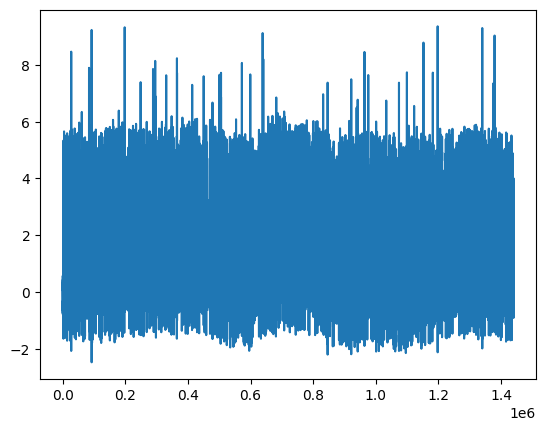

In [101]:
import matplotlib.pyplot as plt

plt.plot(dataset.data)
plt.show()

In [102]:
from cwc.src.data import SignalProcessor

processor = SignalProcessor(dataset)
processor.apply_band_pass_filter(filter_low=300, filter_high=3000, sample_rate=25000, order=4)

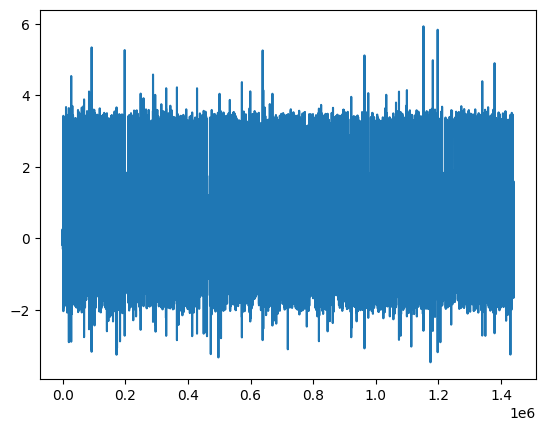

In [103]:
import matplotlib.pyplot as plt

plt.plot(processor.filtered_data)
plt.show()

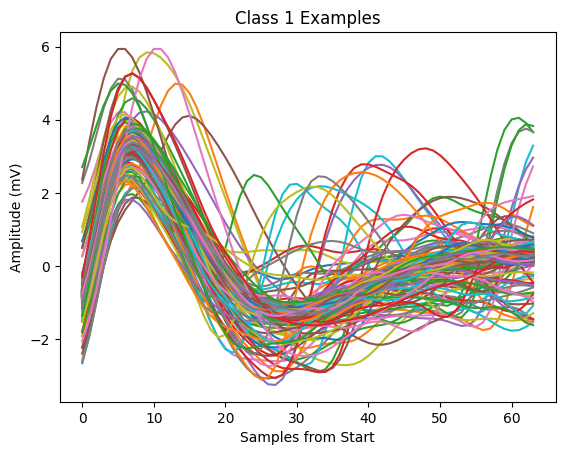

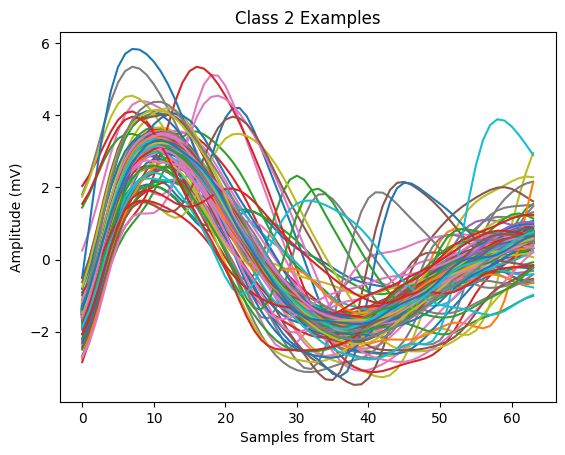

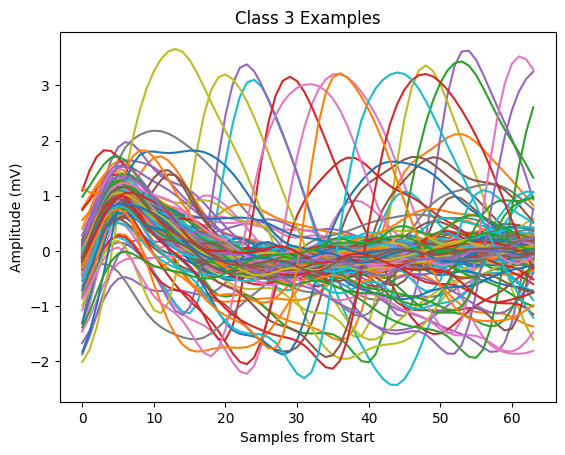

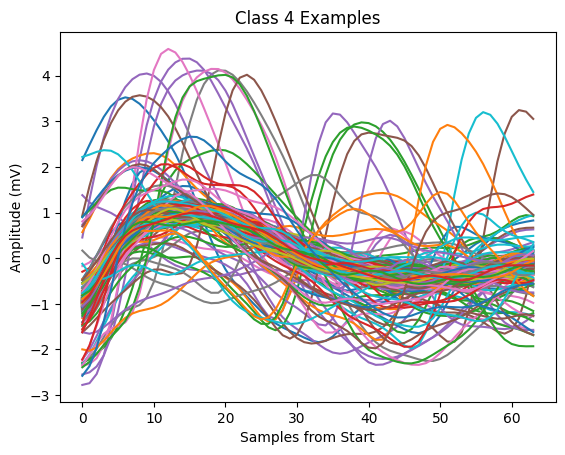

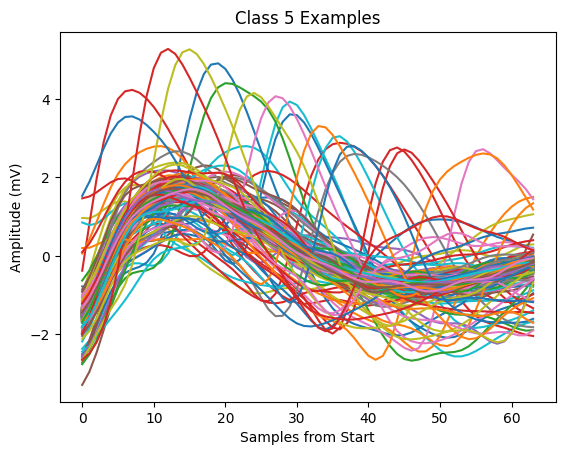

In [104]:
processor.extract_spikes(window_size=64)

# Plot 10 examples per class
classes = dataset.classes
unique_classes = np.unique(classes)

for cls in unique_classes:

    class_indices = np.where(classes == cls)[0] 
    plt.figure() 

    for i in class_indices:
        plt.plot(processor.spikes[i])
        
    plt.title(f'Class {cls} Examples')
    plt.xlabel('Samples from Start')
    plt.ylabel('Amplitude (mV)')
    plt.show()

In [105]:
processor.compute_offsets()

print("Computed Offsets:")
print("\tMean offset:", processor.mean_offset)
print("\tStd offset:", processor.std_offset)
print("\tMin offset:", processor.min_offset)
print("\tMax offset:", processor.max_offset)


Computed Offsets:
	Mean offset: 11.038143382352942
	Std offset: 8.337708737665725
	Min offset: 0
	Max offset: 63


In [106]:
processor.calculate_mad()

# binary search for mad gain

min_gain = 1.0
max_gain = 20.0

threshold = 0.1
difference = 100

mad_gain = 0.0

while (abs(difference) > threshold):

    mad_gain = (min_gain + max_gain) / 2.0
    processor.detect_spikes(mad_gain=mad_gain, distance=25)

    difference = len(processor.detected_spikes) - len(dataset.indices)

    if difference < 0:
        max_gain = mad_gain
    else:
        min_gain = mad_gain

print(f"\nDetected {len(processor.detected_spikes)} spikes")
print(f"True number of spikes = {len(dataset.indices)} spikes")
print(f"Difference = {len(processor.detected_spikes) - len(dataset.indices)} spikes")
print("Final MAD Gain:", mad_gain)




Detected 2176 spikes
True number of spikes = 2176 spikes
Difference = 0 spikes
Final MAD Gain: 9.48550796508789


In [107]:
# align detected spikes

processor.align_spikes(target_peak_pos=20, window_size=64)

print("\nAligned Spikes count", len(processor.aligned_spikes))
print("Aligned spikes shape", processor.aligned_spikes.shape)


Aligned Spikes count 2176
Aligned spikes shape (2176, 64)


In [108]:
processor.extract_features()

print(f"PCA reduced from 64 → {processor.features.shape[1]} dimensions")
print(f"Explained variance ratio (first 6): {processor.pca.explained_variance_ratio_[:]}")
print(f"Total variance kept: {processor.pca.explained_variance_ratio_.sum():.4f}")

PCA reduced from 64 → 8 dimensions
Explained variance ratio (first 6): [0.49753383 0.22189328 0.11592138 0.07177505 0.03998527 0.01307569
 0.00998937 0.00811566]
Total variance kept: 0.9783


In [109]:
from cwc.src.classifier import Classifier

processor.correlate_classes(distance_threshold=25)

print(f"\nKept {len(processor.correlated_classes)} out of {len(processor.aligned_spikes)} total aligned spikes")


classifier = processor.create_classifier()
classifier.train()

print(f"Training accuracy: {classifier.accuracy:.4f}")


Kept 1923 out of 2176 total aligned spikes
Training accuracy: 1.0000


In [110]:
indices, classes = processor.classify_detected_spikes(classifier=classifier)

print(f"\nClassified {len(indices)} spikes")


Classified 1923 spikes


In [111]:
# compare classified spikes with true spikes
true_indices = dataset.indices
true_classes = dataset.classes

correct_classifications = 0
incorrect_classifications = 0

for i in range(len(true_indices)):
    true_idx = true_indices[i]
    true_cls = true_classes[i]
    
    # find closest detected spike
    closest_idx = min(indices, key=lambda x: abs(x - true_idx))
    detected_cls = classes[np.where(indices == closest_idx)[0][0]]

    if true_cls == detected_cls:
        correct_classifications += 1
    else:
        incorrect_classifications += 1
    
print(f"\nCorrect Classifications: {correct_classifications}")
print(f"Incorrect Classifications: {incorrect_classifications}")


Correct Classifications: 1809
Incorrect Classifications: 367


In [ ]:
from cwc.src.classifier import Classifier

processor.calculate_mad()

# binary search for mad gain

min_gain = 1.0
max_gain = 20.0

threshold = 40
best_incorrect = 1000

mad_gain = 0.0

while (best_incorrect > threshold):

    mad_gain = (min_gain + max_gain) / 2.0
    processor.detect_spikes(mad_gain=mad_gain, distance=25)
    processor.align_spikes(target_peak_pos=20, window_size=64)
    processor.extract_features()

    processor.correlate_classes(distance_threshold=25)

    classifier = processor.create_classifier()
    classifier.train()

    indices, classes = processor.classify_detected_spikes(classifier=classifier)


    # compare classified spikes with true spikes
    true_indices = dataset.indices
    true_classes = dataset.classes

    correct_classifications = 0
    incorrect_classifications = 0

    for i in range(len(true_indices)):
        true_idx = true_indices[i]
        true_cls = true_classes[i]
        
        # find closest detected spike
        closest_idx = min(indices, key=lambda x: abs(x - true_idx))
        detected_cls = classes[np.where(indices == closest_idx)[0][0]]

        if true_cls == detected_cls:
            correct_classifications += 1
        else:
            incorrect_classifications += 1
            
    if incorrect_classifications < best_incorrect:
        max_gain = mad_gain
    else:
        min_gain = mad_gain

    if incorrect_classifications < best_incorrect:
        best_incorrect = incorrect_classifications

    print(f"\nDetected {len(processor.detected_spikes)} spikes")
    print(f"Correct Classifications: {correct_classifications}")
    print(f"Incorrect Classifications: {incorrect_classifications}")




Detected 1829 spikes
Correct Classifications: 1483
Incorrect Classifications: 693

Detected 3483 spikes
Correct Classifications: 2124
Incorrect Classifications: 52

Detected 5389 spikes
Correct Classifications: 2130
Incorrect Classifications: 46

Detected 10550 spikes
Correct Classifications: 2135
Incorrect Classifications: 41

Detected 21447 spikes
Correct Classifications: 2136
Incorrect Classifications: 40

Detected 28767 spikes
Correct Classifications: 2136
Incorrect Classifications: 40

Detected 25187 spikes
Correct Classifications: 2136
Incorrect Classifications: 40

Detected 23293 spikes
Correct Classifications: 2136
Incorrect Classifications: 40

Detected 22402 spikes
Correct Classifications: 2136
Incorrect Classifications: 40


KeyboardInterrupt: 

In [ ]:
# now use best mad_gain found
unlabelled_datasets = ["cwc/data/D2.mat", "cwc/data/D3.mat", "cwc/data/D4.mat", "cwc/data/D5.mat", "cwc/data/D6.mat"]

for data_path in unlabelled_datasets:
    print(f"\nProcessing unlabelled dataset: {data_path}")
    dataset.load_from_mat_unlabelled(data_path)
    processor = SignalProcessor(dataset)
    processor.apply_band_pass_filter(filter_low=300, filter_high=3000, sample_rate=25000, order=4)
    processor.extract_spikes(window_size=64)
    processor.compute_offsets()
    processor.calculate_mad()
    processor.detect_spikes(mad_gain=mad_gain, distance=25)
    processor.align_spikes(target_peak_pos=20, window_size=64)
    processor.extract_features()
    processor.correlate_classes(distance_threshold=25)
    indices, classes = processor.classify_detected_spikes(classifier=classifier)
    print(f"Classified {len(indices)} spikes in unlabelled dataset.")

    dataset.write_to_mat(data_path.replace("cwc/data/", "cwc/data/output/"), indices, classes)